## A3 Classification

*Sarah Houlton*

In this assignment we define a new class named `NeuralNetworkClassifier`. It extends the given class `NeuralNetwork` and redefines some methods to do classification.

To do classification, we will redefine the methods:
```
__init__
__repr__
_standardizeT
_unstandardizeT
_forward_pass
_objectiveF
_objective_to_actual
train
use
```

## Definition of `NeuralNetworkClassifier`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys

import torch
import mlutilities as ml  # for ml.draw
import optimizers as opt  # for opt.sgd, opt.adam, and opt.scg

import neuralnetworks as nn

# Extend the nn.NeuralNetwork class to reuse much of its implementation
# Only those methods that must be altered to do classification are defined in NeuralNetworkClassifier

class NeuralNetworkClassifier(nn.NeuralNetwork):

    # Constructor
    def __init__(self, n_inputs, n_hiddens_list, classes, use_torch=False):

        # Force n_hidens_list to be a list
        
        if not isinstance(n_hiddens_list, list):
            raise Exception('NeuralNetworkClassifier: n_hiddens_list must be a list.')
 
        # Call the constructor for NeuralNetwork, passing in the number of unique class names (ints)
        # as the number of outputs
        
        super().__init__(n_inputs, n_hiddens_list, len(classes), use_torch)

        # Store as member variables other things needed by instances of this class.
        
        self.classes = np.array(classes) # to allow argmax in use()
        
        if use_torch:
            self.log = torch.log
            self.exp = torch.exp
        else:
            self.log = np.log
            self.exp = np.exp
    

    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs}, use_torch={self.use_torch})'
        if self.trained:
            str += f'\n   Network was trained for {self.n_epochs} epochs'
            str += f' that took {self.training_time:.4f} seconds. Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
        
    def _standardizeT (self, T):
        return T
    
    def _unstandardizeT (self, T):
        return T
    
    
    def _forward_pass(self, X):
        # Assume weights already unpacked
        Z_prev = X  # output of previous layer
        Z = [Z_prev]
        for i in range(self.n_hidden_layers):
            V = self.Vs[i]
            Z_prev = self.tanh(Z_prev @ V[1:, :] + V[0:1, :])
            Z.append(Z_prev)
        Y = Z_prev @ self.W[1:, :] + self.W[0:1, :]
        
        fs = np.exp(Y)  # N x K
        denom = np.sum(fs, axis=1).reshape((-1,1))
        Y = fs / denom
        
        return Y, Z
        
    def _objectiveF(self, w, X, T):             
        self._unpack(w)
        Y, _ = self._forward_pass(X)
        return -self.mean(np.log(Y) * T)
    
    def _objective_to_actual(self, neg_mean_log_likelihood):
        return self.exp(- neg_mean_log_likelihood)
    
                
    def train(self, X, T, n_epochs, method='scg', verbose=False, save_weights_history=False, learning_rate=0.001,
              momentum_rate=0.0): # only for sgd and adam          

        if X.shape[1] != self.n_inputs:
            raise Exception(f'train: number of columns in X ({X.shape[1]}) not equal to number of network inputs ({self.n_inputs})')
        
        if self.use_torch:
            X = torch.tensor(X, dtype=torch.float)  # 32 bit
            T = torch.tensor(T, dtype=torch.float)
        
        
        if T.ndim == 1:
            T = T.reshape((-1,1)) 
        TI = (T == np.unique(T)).astype(int)
        print(TI[:10, :])
        
        self._setup_standardize(X, TI)
        X = self._standardizeX(X)
        TI = self._standardizeT(TI)
        
        try:
            algo = [opt.sgd, opt.adam, opt.scg][['sgd', 'adam', 'scg'].index(method)]
        except:
            raise Exception("train: method={method} not one of 'scg', 'sgd' or 'adam'")            

        result = algo(self._pack(self.Vs, self.W), self._objectiveF, [X, TI], n_epochs, self._gradientF,  # not used if scg
                      eval_f=self._objective_to_actual, learning_rate=learning_rate, momentum_rate=momentum_rate, verbose=verbose,
                      use_torch=self.use_torch, save_wtrace=save_weights_history)

        self._unpack(result['w'])
        self.reason = result['reason']
        self.error_trace = result['ftrace'] # * self.Tstds # to _unstandardize the MSEs
        self.n_epochs = len(self.error_trace) - 1
        self.trained = True
        self.weight_history = result['wtrace'] if save_weights_history else None
        self.training_time = result['time']
        return self
        
    def use(self, X, all_outputs=False):        
        if self.use_torch:
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float)
        X = self._standardizeX(X)
        Y, Z = self._forward_pass(X)
        Y = self._unstandardizeT(Y)
        if self.use_torch:
            Y = Y.detach().cpu().numpy()
            Z = [Zi.detach().cpu().numpy() for Zi in Z]
        max_indices = np.argmax(Y, axis = 1)
        Y_classes = self.classes[max_indices]
        Y_classes = Y_classes.reshape(-1, 1)
        return (Y_classes, Y, Z[1:]) if all_outputs else (Y_classes, Y)         
        

## Example Tests

Here are some tests of individual parts of the code to verify each piece.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetworks as nn

Here we create some toy data to run the neural network on.  Each sample has two inputs, randomly chosen from integers 0, 1, and 2.  Target class is 1 if the two input samples are equal, 0 if they are not.

In [3]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

n_samples = 20
X = np.random.choice(3, (n_samples, 2))
T = (X[:, 0:1] == X[:, 1:2]).astype(int)  # where the two inputs are equal
classes = [0, 1]

for x, t in zip(X, T):
    print(f'x = {x}, t = {t}')

x = [2 0], t = [0]
x = [2 2], t = [1]
x = [0 0], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [2 2], t = [1]
x = [0 2], t = [0]
x = [1 0], t = [0]
x = [1 1], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [0 2], t = [0]
x = [2 2], t = [1]
x = [1 2], t = [0]
x = [1 1], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [0 2], t = [0]


In [4]:
print(f'{np.sum(T==0)} not equal, {np.sum(T==1)} equal')

8 not equal, 12 equal


In [5]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet_new = NeuralNetworkClassifier(2, [10, 10], [0, 1])
nnet_new

NeuralNetworkClassifier(2, [10, 10], 2, use_torch=False)  Network is not trained.

We will not be standardizing targets T for this network, so we must redefine the two relevant functions so they just return their argument.

In [6]:
nnet_new._standardizeT(T)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [7]:
nnet_new._unstandardizeT(T)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

The standardization functions from the parent class will be available to us.

In [8]:
nnet_new._setup_standardize(X, T)
Xst = nnet_new._standardizeX(X)
Xst

array([[ 1.08347268, -1.47709789],
       [ 1.08347268,  0.98473193],
       [-1.32424438, -1.47709789],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193],
       [-0.12038585, -1.47709789],
       [-0.12038585, -0.24618298],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-1.32424438,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-0.12038585,  0.98473193],
       [-0.12038585, -0.24618298],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193]])

In [9]:
Y, Z = nnet_new._forward_pass(Xst)
Y

array([[0.55163905, 0.44836095],
       [0.52855705, 0.47144295],
       [0.59590952, 0.40409048],
       [0.5358871 , 0.4641129 ],
       [0.52855705, 0.47144295],
       [0.52855705, 0.47144295],
       [0.59746461, 0.40253539],
       [0.57163885, 0.42836115],
       [0.56395347, 0.43604653],
       [0.56395347, 0.43604653],
       [0.59590952, 0.40409048],
       [0.56395347, 0.43604653],
       [0.59590952, 0.40409048],
       [0.59746461, 0.40253539],
       [0.52855705, 0.47144295],
       [0.56007003, 0.43992997],
       [0.56395347, 0.43604653],
       [0.5358871 , 0.4641129 ],
       [0.52855705, 0.47144295],
       [0.59746461, 0.40253539]])

In [10]:
w = nnet_new._pack(nnet_new.Vs, nnet_new.W)

T_indicator_vars = np.hstack((1 - T, T))  # this only works for this particular two-class toy data

nnet_new._objectiveF(w, X, T_indicator_vars)

0.3525328777771416

Now, for the workhorses, the functions the user of your class will use.

In [11]:
nnet_new.train(X, T, 100)

[[1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]]


NeuralNetworkClassifier(2, [10, 10], 2, use_torch=False)
   Network was trained for 66 epochs that took 0.0908 seconds. Final objective value is 1.000

In [12]:
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape

((20, 1), (20, 2))

Let's plot target and predicted classes. Shift the predicted class a bit upward to we can see it.

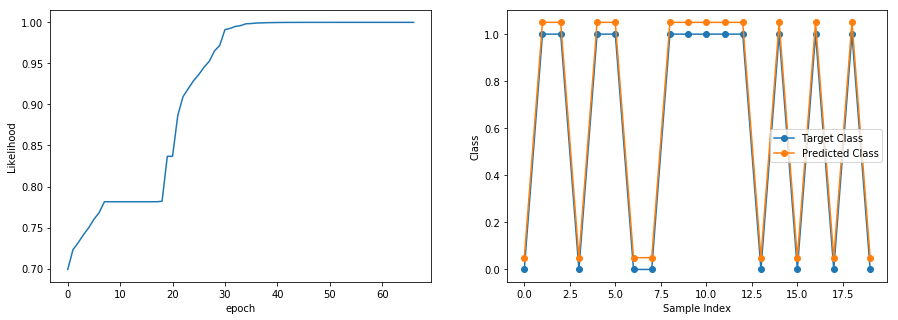

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

On this toy data, we can see that the certainty increased through the epochs until it was 100% certain about its classifications. In examining the data next to the predictions, we can see that the model was indeed correct.

## Real Data Set


To test on a real dataset, I've chosen the Parkinsons dataset, available at https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/. The code below divides it into X and T to be used in nnet classifier.

In [14]:
def loadData(filename='covtype.data'):
    with open(filename,"r") as f:
        names = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
        'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
        'Rawah_Wilderness_Area', 'Neota_Wilderness_Area', 'Comanche_Peak_Wilderness_Area', 'Cache_la_Poudre_Wilderness_Area',
        '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
        '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33','34', '35', '36', '37', '38', '39',
        '40', 'Cover_Type']

        data = np.loadtxt(f, delimiter=',')

    targetColumn = names.index("Cover_Type")
    XColumns = np.arange(54)
    XColumns = np.delete(XColumns, targetColumn - 1)
    X = data[:,XColumns]
    T = data[:,targetColumn].reshape((-1,1)) # to keep 2-d matrix form
    names.remove("Cover_Type")
    return X,T,names

In [15]:
X, T, names = loadData()

In [16]:
def loadParkinsonsData(filename='parkinsons.data'):
    with open(filename,"r") as f:
        header = f.readline()
        names = header.strip().split(',')[1:]

        data = np.loadtxt(f, delimiter=',', usecols=1+np.arange(23))

    targetColumn = names.index("status")
    XColumns = np.arange(23)
    XColumns = np.delete(XColumns, targetColumn)
    X = data[:,XColumns]
    T = data[:,targetColumn].reshape((-1,1)) # to keep 2-d matrix form
    names.remove("status")
    return X,T,names

In [17]:
X,T,names = loadParkinsonsData()
X.shape, T.shape, names

((195, 22),
 (195, 1),
 ['MDVP:Fo(Hz)',
  'MDVP:Fhi(Hz)',
  'MDVP:Flo(Hz)',
  'MDVP:Jitter(%)',
  'MDVP:Jitter(Abs)',
  'MDVP:RAP',
  'MDVP:PPQ',
  'Jitter:DDP',
  'MDVP:Shimmer',
  'MDVP:Shimmer(dB)',
  'Shimmer:APQ3',
  'Shimmer:APQ5',
  'MDVP:APQ',
  'Shimmer:DDA',
  'NHR',
  'HNR',
  'RPDE',
  'DFA',
  'spread1',
  'spread2',
  'D2',
  'PPE'])

In [18]:
nnetPark = NeuralNetworkClassifier(22, [0], names)
nnetPark

NeuralNetworkClassifier(22, [0], 22, use_torch=False)  Network is not trained.

In [19]:
nnetPark.train(22, T, 100)

AttributeError: 'int' object has no attribute 'shape'

# Grading

Download [A3grader.zip](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.zip) and extract A3grader.py from it. Run the code in the following cell to demonstrate an example grading session. You should see a perfect execution score of 80/80 if your functions are defined correctly. Other tests will be performed on your checked in notebook to make up the 80 execution points. The remaining 20 points will be based on the results you obtain from the classification data you download and your discussion of the results.

In [20]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Houlton-A1.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing if your NeuralNetworkClassifier can learn to detect vowels when given
their ascii codes.

import numpy as np
ascii_code = list(range(65, 91)) + list(range(97, 123))
chars = [chr(n).lower() for n in ascii_code]
vowel = [c in ['a', 'e', 'i', 'o', 'u'] for c in chars]
X = np.array(ascii_code).reshape((-1, 1))
T = np.array(vowel).reshape((-1, 1))
classes = np.unique(T)

np.random.seed(120)
nnet = NeuralNetworkClassifier(X.shape[1], [50, 20, 20], classes)
nnet.train(X, T, 10000, verbose=True)
Yc, Y = nnet.use(X)
n_correct = (Yc == T).sum()
print(f'{n_correct} out of {T.shape[0]} samples, or {n_correct/T.shape[0]*100:.2f} percent.')
[[0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]
SCG: Iteration 1000 ObjectiveF=0.79674 Scale=

A3grader.py:70: RuntimeWarning: invalid value encountered in true_divide
  not isinstance(node, ast.Import)):  #  and
A3grader.py:77: RuntimeWarning: divide by zero encountered in log
  exec(code, module.__dict__)
A3grader.py:77: RuntimeWarning: invalid value encountered in multiply
  exec(code, module.__dict__)


SCG: Iteration 2000 ObjectiveF=0.81498 Scale=4.295e-06 Seconds=2.407
SCG: Iteration 3000 ObjectiveF=0.82431 Scale=1.000e-15 Seconds=2.205
SCG: Iteration 4000 ObjectiveF=0.83966 Scale=1.000e-15 Seconds=2.164
SCG: Iteration 5000 ObjectiveF=0.86282 Scale=1.000e-15 Seconds=1.920
SCG: Iteration 6000 ObjectiveF=0.88038 Scale=1.000e-15 Seconds=1.932
SCG: Iteration 7000 ObjectiveF=0.91337 Scale=1.000e-15 Seconds=1.912
SCG: Iteration 8000 ObjectiveF=0.93573 Scale=1.000e-15 Seconds=1.956
SCG: Iteration 9000 ObjectiveF=0.95141 Scale=1.000e-15 Seconds=1.926
SCG: Iteration 10000 ObjectiveF=0.96361 Scale=1.000e-15 Seconds=1.843
51 out of 52 samples, or 98.08 percent.

--- 80/80 points. Returned correct value of 51.

C:\Users\Sarah\Documents\Sarah\Grad Comp Sci\CS 545 Execution Grade is 80 / 80

 __ / 10 You obtained data for a classification problem and set up
         X and T matrices correctly.

 __ / 10 You compared several different network sizes, numbers of
         epochs, and optimization alg

<Figure size 432x288 with 0 Axes>